# Problem 4.2 

Attribution: Michelle

First, we load in the necessary modules and the dataset.

In [1]:
# Our numerical workhorses
import numpy as np
import pandas as pd

# Our main MCMC package
import emcee

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Seaborn, useful for graphics
import seaborn as sns

# Corner is useful for displaying MCMC results
import corner

%matplotlib inline

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2,
      'axes.labelsize': 18,
      'axes.titlesize': 18,
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Load data
df = pd.read_csv('data/hiv_data.csv', comment = '#')

The Perelson model for the viral load data is given to us as:
\begin{align}
V(t) = V_0e^{-ct} + \frac{cV_0}{c - \delta}\big[\frac {c}{c - \delta}(e^{-\delta t} - e^{-ct}) - \delta te^{-ct}\big]
\end{align}
So we define the Perelson model as our viral load model.

In [2]:
# We want to define our viral load from the equation given in the problem
def ViralLoad(params, t):
    '''
    Defines V(t) with limits
    '''
    
    # Unpack paramerters
    V_0, c, delta= params
    
    # Limit our V(t)
    if abs(c - delta) < 1e-9:
        return V_0 * (1 + delta*t + (delta * t)**2 / 2) * np.exp(-delta * t)
    
    # define the equation in the brackets for V(t) cause it's so long
    bracket = c / (c - delta) * (np.exp(-delta * t) - np.exp(-c * t)) - delta * t * np.exp(-c * t)
    
    return V_0 * np.exp(-c * t) + c * V_0 / (c - delta) * bracket


We want to take advantage of using the log of our posterior so we have to adjust our parameters accordingly.

In [3]:
# We want a log of our posterior so we have to adjust our parameters
def ViralLoadParam(params, t):
    '''
    Viral load parameters with log parameters
    '''
    return ViralLoad(np.exp(params), t)

Our posterior is a student-t distribution. The variance is unknown so we marginalize it. 
\begin{align}
P(V_0, c, \delta \mid t, V, I) = \big(\Sigma\big(V -  (V_0e^{-ct} + \frac{cV_0}{c - \delta}\big[\frac {c}{c - \delta}(e^{-\delta t} - e^{-ct}) - \delta te^{-ct}\big]\big)^2\big)^{t/2}
\end{align}

In [4]:
# Our posterior is a student-t distribution, marginalize the unknown variance
def resid(params, t, V):
    '''
    Residuals for viral load
    '''
    return V - ViralLoadParam(params, t)

# Define our posterior
def log_posterior(params, t, V):
    '''
    Log posterior of our HIV data
    '''
   
    V_0, c, delta = params
    
    # set limits on our parameters
    if c < 0 or c > 10 or delta < 0 or delta > 10 or V_0 < 0:
        return -np.inf
    
    return -len(t) / 2 * np.log(np.sum(resid(np.log(params), t, V)**2))

Now we pass our transcript counts as arguments.

In [5]:
args = (df['Days after administration'], df['RNA copies per mL'])

Now we define the specifications to use MCMC.

In [6]:
# Number of parameters
ndim = 3

# Define number of walkers
nwalkers = 50

# Define the number of walkers to burn
nburn = 500

# Define the number of steps MCMC will take after the burn
nsteps = 5000

# For reproducibility seed random number generator
np.random.seed(42)

We need to tell the walkers where to start. $p_0[i,j]$ is the starting point where i is the walkers and j is the parameters. We want our parameters c and $\delta$ to call random numbers from the interval (0, 10) and to call nwalkers. Our V_0 can be any postivie number so we are picking random numbers from an exponential distribution.

In [7]:
# Define where the walkers start
# p0[i,j] where i is walkers and j is parameters
# we want c and delta for interval 0 to 10
p0 = np.empty((nwalkers, ndim))
p0[:,0] = np.random.exponential(1, nwalkers)
p0[:,1] = np.random.uniform(0, 10, nwalkers)
p0[:,2] = np.random.uniform(0, 10, nwalkers)

Next we instantiate our sampler.

In [8]:
# Now we instantiate the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args = args)

Now we have to do a burn-in.

In [9]:
# burn the sampler in
pos, prob, state = sampler.run_mcmc(p0, nburn, storechain = False)

And lastly we run the sampler

In [10]:
# sample
_ = sampler.run_mcmc(pos, nsteps)

//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
//anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


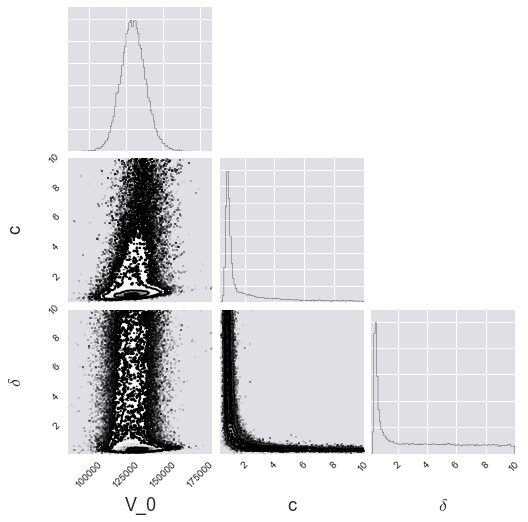

In [11]:
fig = corner.corner(sampler.flatchain, labels=['V_0', 'c', '$\delta$'], bins=100)

We have re-created the plot from problem 3.3b. It is the right bottom contour plot. We see that the posterior distributions for c and $\delta$ are both very far from Gaussian. $\delta$ begins to level out around 2 whereas c decays to 0. From the contour plot of $\delta$ vs c, we can see that for small values of c, $\delta$ could practically be any value -- and vice versa for c in the case of a low value for $\delta$. 

We can print our most probable parameter set and compare it to the set from problem 3.3b:
\begin{align}
V_0 = 1.29e+05 ± 7.44e+03 \,\,\text{copies of RNA/mL}
\end{align}
\begin{align}
c = 2.64 ± 1.56 \,\,\text{days}^{-1}
\end{align}
\begin{align}
δ = 0.53 ± 0.19 \,\,\text{days}^{-1}
\end{align}


In [12]:
# Get the index of the most probable parameter set
     ...: max_ind = np.argmax(sampler.flatlnprobability)
     ...: 
     ...: # Pull out values.
     ...: V_0_MAP, c_MAP, delta_MAP = sampler.flatchain[max_ind,:]
     ...: 
     ...: # Print the results
     ...: print("""
     ...: Most probable parameter values:
     ...: V_0: {0:.3f} copies of mRNA/mL
     ...: c:  {1:.3f} /days
     ...: delta: {2:.3f} /days
     ...: """.format(V_0_MAP, c_MAP, delta_MAP))



Most probable parameter values:
V_0: 129612.683 copies of mRNA/mL
c:  2.629 /days
delta: 0.534 /days



This is the same values as we got from finding the MAP. 